In [1]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/nebula-data/nebula.tif
/kaggle/input/star-dataset/stars.jpg


## Importing Necessary Libraries

In [2]:
import numpy as np 
import pandas as pd 
import os
from __future__ import division
from skimage import io
import math
from matplotlib import pyplot as plt
import scipy.ndimage as sc
from skimage.measure import label
from skimage import io, img_as_float
from skimage.transform import resize
from scipy.ndimage import uniform_filter, label
from sklearn.metrics import mean_squared_error
from math import log10, sqrt

## Guassian Noise & Stars
- In this step we imported the nebula image (orginal image) and an image with stars background.
- Checked if both images have the same size or no.
- Created a function called add_guassian_noise that takes an nebula image and a noise sigma value, creates a copy of the input image, generates Gaussian noise using the dimensions of the image and the noise sigma, adds this noise to the copied image, and returns the resulting noisy image.
- Then we created a starry cloud image that comibnes the nebula and stars image using .clip
- Finally, we displayed the orginal image, guassian noise and starry cloud image

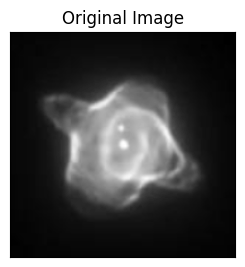

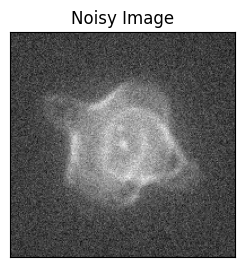

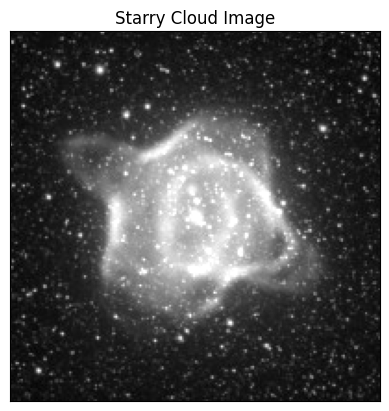

In [4]:
nebula = img_as_float(io.imread('/kaggle/input/nebula-data/nebula.tif', as_gray=True))
stars = img_as_float(io.imread('/kaggle/input/star-dataset/stars.jpg', as_gray=True))
stars = resize(stars, nebula.shape)
plt.subplot(121), plt.imshow(nebula, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.show()
def add_gaussian_noise(image_in, noise_sigma):
    temp_image = np.float64(np.copy(image_in))
    h, w = temp_image.shape[:2] 
    noise = np.random.randn(h, w) * noise_sigma
    noisy_image = temp_image + noise
    return noisy_image
noisy_nebula = add_gaussian_noise(nebula, 0.1)
plt.subplot(121), plt.imshow(noisy_nebula, cmap='gray')
plt.title('Noisy Image'), plt.xticks([]), plt.yticks([])
plt.show()
starry_cloud = np.clip(nebula + stars, 0, 1)
plt.imsave('/kaggle/working/starry_cloud.jpeg', starry_cloud, cmap='gray')
plt.imshow(starry_cloud, cmap='gray')
plt.title('Starry Cloud Image'), plt.xticks([]), plt.yticks([])
plt.show()


## Make Binary Function:
- Defined few variables:
    - **avg_background_intensity = 46:** Average background intensity of image to be processed, to be empirically determined before processing. 46 is the average background intensity of the synthetic image created to test the algorithm. 
    - **neighbourhood_size = 24:** Size of region in pixels to be sampled to determine whether a pixel is in a signal region or background region. This value can be changed without significant impact on the processed image.
    - **signal_intensity_threshold = 2.5:** Regions of the image 2.5 times brighter than the background are defined as part of the signal - a nebula, streak, etc.
    - **signal_size_threshold = 50:** Size threshold in pixels for considering a connected region in the relative residue to be signal rather than star/noise. Should be chosen to reflect the typical scale of signal features in the image.
- Created a function called make_binary. This function creates the 'local stop' by transforming the relative residue into a binary image. A 1 in the local stop means that the corresponding pixel of the image being processed will be modified at the next time step while a 0 indicates that the pixel intensity value will not change. The local stop is updated at each iteration. Input: Original image to be processed, relative residue, iteration of algorithm. Output: A binary image called the local stop which controls the next iteration of the algorithm.

In [5]:
avg_background_intensity = 46
neighbourhood_size = 24
signal_intensity_threshold = 2.5
signal_size_threshold = 50
def make_binary(original_img, relative_residue, iteration):
    # Copies relative residue array for processing
    img = np.float64(relative_residue.copy())
    img[img < 0] = 0  # Sets negative values to 0
    # The section of code below pinpoints pixels in the signal region of the
    # original image where large changes are being made at the specified
    # iteration.
    signal = [] # Initialises list of pixels judged by the algorithm to be signal
    neighbourhood = uniform_filter(
        original_img, neighbourhood_size, mode='reflect')/avg_background_intensity
     # Calculates average value in a neighbourhood around each pixel in the
    # original image and divides it by the average background value to
    # determine whether the pixel is in a signal region or background region.
    # A high ratio means we are in a signal region; a ratio of 1 means we are in a background region.
    xdim, ydim = img.shape
    for i in range(0, xdim):
        for j in range(0, ydim):
            if neighbourhood[i, j] >= signal_intensity_threshold:
                signal.append(img[i, j])
                # For loop checks whether each pixel in the relative residue is in a signal
                #region or background region of the original image and assigns signal values to the signal list
    # Calculates average intensity of the signal appearing in the relative residue
    if len(signal) > 0:
        avg_value = sum(signal) / len(signal)
         # Sets relative residue to 0 if value is less than average. This background is ignored when labelling connected regions.
    # checks connected regions where large changes are being made to the original image at the specified iteration & 
    # decides whether these regions are signal or a star based on a size threshold.
    # Signal regions are then protected while stars may continue to be smoothed away at the next iteration.
    else:
        avg_value = 0  
    img[img > avg_value] = 1
    img[img <= avg_value] = 0
     # Labels connected pixels in the relative residue by an integer starting from 1, 2, 3...
    stop = np.ones_like(img)
    structure = np.ones((3, 3))  # Define the connectivity for the label function
    labelled, _ = label(img, structure=structure)  # Label the features in the image
    regions = np.amax(labelled)  # Number of connected regions
    count_list = []   # Initialises list to count how many pixels are in each
        # labelled region
    for i in range(1, (regions+1)):
                # Counts number of pixels in a connected region i
        count = np.count_nonzero(labelled == i)
        count_list.append(count)
    local_stop = stop + labelled
    for j in range(0, len(count_list)):
        if count_list[j] >= signal_size_threshold:
            local_stop[local_stop == (j+2)] = 0
            # If a connected region contains enough pixels that it must be
            # signal, the local stop is set to 0, stopping diffusion in this region.
        else:
            local_stop[local_stop == (j+2)] = 1
                        # Otherwise, the local stop is set to 1 and diffusion can proceed
    for i in range(0, xdim):
        for j in range(0, ydim):
            if neighbourhood[i, j] < 1.5:
                local_stop[i, j] = 1
                # The local stop is set to 1 in regions considered background,
                # as these can be diffused indefinitely without compromising the signal
    return local_stop
# Read the images
nebula = img_as_float(io.imread('/kaggle/input/nebula-data/nebula.tif', as_gray=True))
stars = img_as_float(io.imread('/kaggle/input/star-dataset/stars.jpg', as_gray=True))
# Ensure the images have the same dimensions
stars = resize(stars, nebula.shape)
# Add Gaussian noise to the nebula image
noisy_nebula = add_gaussian_noise(nebula, 0.1)
# Create the binary image
binary_img = make_binary(noisy_nebula, noisy_nebula, 100)

## Remove stars:
- This function removes background stars from the input image using a diffusion-based method with a novel diffusion coefficient.

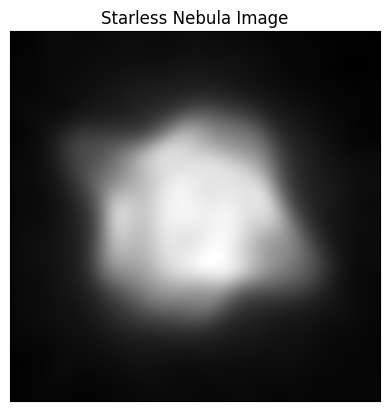

In [6]:
def remove_stars(image_in, nt, gamma=0.25, step=(1., 1.)):
    img = np.float64(np.copy(image_in))  # Copies image for processing
    delta_x, delta_y = np.zeros_like(img), np.zeros_like(
        img)  # Initialises matrices for x- and y-gradients
    S, E, NS, EW = np.zeros_like(img), np.zeros_like(
        img), np.zeros_like(img), np.zeros_like(img)
    # Initialises matrix for diffusion coefficient
    diffusion_coefficient = np.ones_like(img)

    asym, asym0, asym1, asym2, asym3, asym4, asym5 = np.ones_like(img), np.ones_like(img), np.ones_like(
        img), np.ones_like(img), np.ones_like(img), np.ones_like(img), np.ones_like(img)
    # Initialises matrices for asymmetry parameter at different window sizes
    asym[1:-1, 1:-1] = np.abs(img[2:, 1:-1]-img[:-2, 1:-1]) + np.abs(img[1:-1, 2:]-img[1:-1, :-2]) + \
        np.abs(img[2:, :-2]-img[:-2, 2:]) + np.abs(img[2:, 2:]-img[:-2, :-2])
    # Calculates local asymmetry of original, unprocessed image
    # Calculates average local asymmetry of original image
    avg_asym = np.mean(asym)
    kf = 2*avg_asym  # Fixes normalisation constant using initial average local
    # asymmetry

    orig_img = img.copy()
    avg_orig = sc.uniform_filter(orig_img, 3, mode='reflect')
    binary_stop = np.ones_like(img)
    iteration = 0
    res_list = []
    second_res_list = []
    # For loop initialisations
    for timestep in range(nt):

        iteration += 1  # Updates iteration count
        # N-th discrete difference along x-axis
        delta_y[:-1, :] = np.diff(img, axis=0)
        # N-th discrete difference along y-axis
        delta_x[:, :-1] = np.diff(img, axis=1)

        avg_img = sc.uniform_filter(img, 3, mode='reflect')

        asym1[1:-1, 1:-1] = np.abs(img[2:, 1:-1]-img[:-2, 1:-1]) + np.abs(img[1:-1, 2:]-img[1:-1, :-2]) + \
            np.abs(img[2:, :-2]-img[:-2, 2:]) + \
            np.abs(img[2:, 2:]-img[:-2, :-2])
        asym2[2:-2, 2:-2] = np.abs(img[4:, 2:-2]-img[:-4, 2:-2]) + np.abs(img[2:-2, :-4] -
                                                                          img[2:-2, 4:]) + np.abs(img[4:, :-4]-img[:-4, 4:]) + np.abs(img[4:, 4:]-img[:-4, :-4])
        asym3[3:-3, 3:-3] = np.abs(img[6:, 3:-3]-img[:-6, 3:-3]) + np.abs(img[3:-3, :-6] -
                                                                          img[3:-3, 6:]) + np.abs(img[6:, :-6]-img[:-6, 6:]) + np.abs(img[6:, 6:]-img[:-6, :-6])
        asym4[4:-4, 4:-4] = np.abs(img[8:, 4:-4]-img[:-8, 4:-4]) + np.abs(img[4:-4, :-8] -
                                                                          img[4:-4, 8:]) + np.abs(img[8:, :-8]-img[:-8, 8:]) + np.abs(img[8:, 8:]-img[:-8, :-8])
        asym5[5:-5, 5:-5] = np.abs(img[10:, 5:-5]-img[:-10, 5:-5]) + np.abs(img[5:-5, :-10]-img[5:-5, 10:]) + \
            np.abs(img[10:, :-10]-img[:-10, 10:]) + \
            np.abs(img[10:, 10:]-img[:-10, :-10])
        # Calculates local asymmetry in 5 window sizes

        asymavg = ((asym1+asym2+asym3+asym4+asym5)/5)
        # Averages local asymmetry over 5 window sizes

        if iteration <= 2:
            asym0 = asymavg*np.exp(((avg_img/avg_background_intensity)-1))
            # Weights average local asymmetry by enhancement factor
        else:
            asym0 = asymavg * \
                np.exp(((avg_img/avg_background_intensity)/(binary_stop)-1))
            # From iteration 3, weights average local asymmetry by enhancement
            # factor and applies local stop constructed using the make_binary
            # function above

        diffusion_coefficient = (1./(1. + (asym0/kf))/step[0])
        # Calculates diffusion coefficient

        S[:] = diffusion_coefficient*delta_y
        E[:] = diffusion_coefficient*delta_x
        # Multiplies image gradient by new diffusion coefficient

        NS[:] = S
        EW[:] = E
        NS[1:, :] -= S[:-1, :]
        EW[:, 1:] -= E[:, :-1]
        # Subtracts a copy that has been shifted 'North/West' by one
        # pixel. Don't ask questions. Just do it. Trust me.
        # (comment courtesy of Muldal 2012)

        img += gamma*(NS+EW)  # Updates image

        avg_imgnew = sc.uniform_filter(img, 3, mode='reflect')
        res = np.abs(avg_orig - avg_imgnew)
        res_list.append(res)
        # Calculates residue by differencing original image and updated image
        # Stores residue in a list

        if iteration > 1:
            second_res = res_list[iteration-1] - res_list[iteration-2]
            second_res_list.append(second_res)
            # Calculates relative residue by differencing two absolute residues
            # Stores relative residue in a list
        if iteration > 4:
            avg_second_res = (second_res_list[iteration-2] + second_res_list[iteration-3] +
                              second_res_list[iteration-4] + second_res_list[iteration-5])/4
            binary_stop = make_binary(orig_img, avg_second_res, iteration)
            # Average relative residues of preceding 4 iterations
            # Inputs averaged relative residue to make_binary function to
            # construct the local stop

    return img
nebula = img_as_float(io.imread('/kaggle/input/nebula-data/nebula.tif', as_gray=True))
stars = img_as_float(io.imread('/kaggle/input/star-dataset/stars.jpg', as_gray=True))
stars = resize(stars, nebula.shape)
noisy_nebula = add_gaussian_noise(nebula, 0.1)
starless_nebula = remove_stars(noisy_nebula, 100)
plt.imshow(starless_nebula, cmap='gray')
plt.title('Starless Nebula Image'), plt.xticks([]), plt.yticks([])
plt.show()

In [7]:
def compute_psnr(starless_nebula, starry_cloud):
    assert starless_nebula.shape == starry_cloud.shape, "Images must be the same shape."
    mse = np.mean((starless_nebula - starry_cloud) ** 2)
    print(f"MSE: {mse}")
    # If the MSE is zero, the images are identical
    if mse == 0:
        print("The images are identical.")
        return
    # Calculate the PSNR
    max_pixel = 255.0
    psnr = 20 * math.log10(max_pixel / math.sqrt(mse))
    print(f"PSNR: {psnr} dB")
compute_psnr(starless_nebula, starry_cloud)

MSE: 0.017335818688750344
PSNR: 65.7413600471622 dB


## Apply Morphological Filter:
- Erosion
- Dilation
- Opening
- Closing 

In [8]:
##Dilation Morphological Filter: Enlarges bright regions and shrinks dark regions.
def dilation_filter(starry_cloud, kernel):
    output = np.zeros_like(starry_cloud)
    krc = kernel.shape[0] // 2
    kcc = kernel.shape[1] // 2
    for i in range(krc, starry_cloud.shape[0] - krc):
        for j in range(kcc, starry_cloud.shape[1] - kcc):
            maxi = starry_cloud[i][j]
            for x in range(kernel.shape[0]):
                for z in range(kernel.shape[1]):
                    if kernel[x][z] == 1 and np.all(starry_cloud[i + x - krc, j + z - kcc] > maxi):
                        maxi = starry_cloud[i + x - krc, j + z - kcc]
            output[i, j] = maxi
    return output
## Erosion Morphological Filter: Enlarges dark regions and shrinks bright regions.
def erosion_filter(starry_cloud, kernel):
    output1 = np.zeros_like(starry_cloud)
    krc = kernel.shape[0] // 2
    kcc = kernel.shape[1] // 2
    for i in range(krc, starry_cloud.shape[0] - krc):
        for j in range(kcc, starry_cloud.shape[1] - kcc):
            mini = starry_cloud[i][j]
            for x in range(kernel.shape[0]):
                for z in range(kernel.shape[1]):
                    if kernel[x][z] == 1 and np.all(starry_cloud[i + x - krc, j + z - kcc] < mini):
                        mini = starry_cloud[i + x - krc, j + z - kcc]
            output1[i, j] = mini
    return output1
## Opening Morphological Filter: Erodes an image & then dilates the eroded image.
def opening_filter(starry_cloud, kernel):
    return dilation_filter(erosion_filter(starry_cloud, kernel), kernel)
## Closing Morphological Filter: Dilates an image & then Erodes the dilated image.
def closing_filter(starry_cloud, kernel):
    return erosion_filter(dilation_filter(starry_cloud, kernel), kernel)

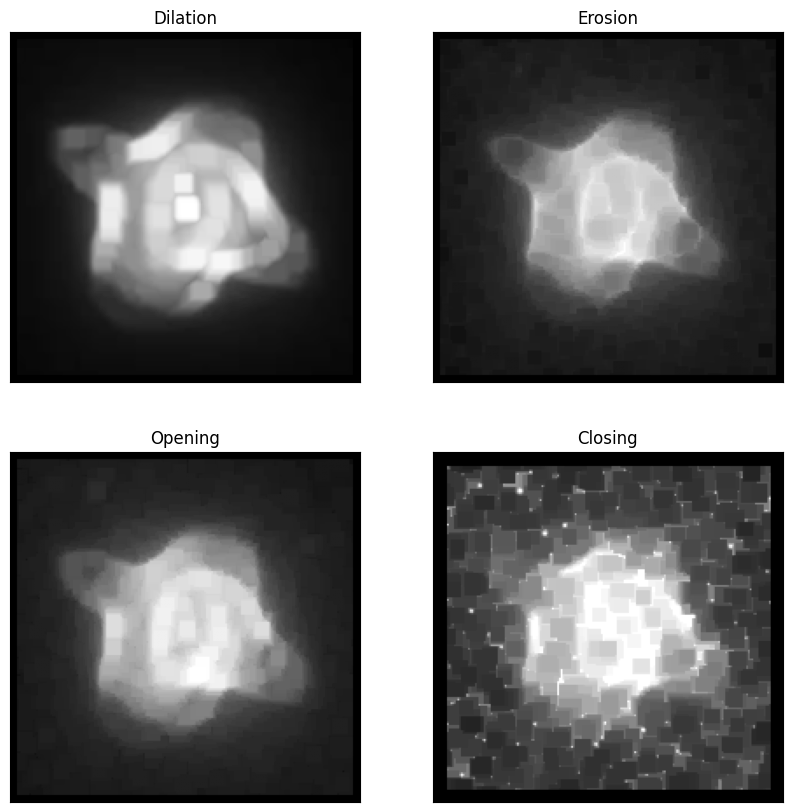

In [9]:
# Apply the morphological filters by calling their functions
kernel = np.ones((8,8))
Dilated_image = dilation_filter(nebula, kernel)
Eroded_image = erosion_filter(starry_cloud, kernel)
Opening_image = opening_filter(starry_cloud, kernel)
Closing_image = closing_filter(starry_cloud, kernel)

# Plot the morphological images:
plt.figure(figsize=(10,10))
plt.subplot(221), plt.imshow(Dilated_image, cmap='gray')
plt.title('Dilation'), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(Eroded_image, cmap='gray')
plt.title('Erosion'), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(Opening_image, cmap='gray')
plt.title('Opening'), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(Closing_image, cmap='gray')
plt.title('Closing'), plt.xticks([]), plt.yticks([])
plt.show()

In [17]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal; Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr

def calculate_mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

psnr_dilated = calculate_psnr(Dilated_image,starry_cloud )
mse_dilated = calculate_mse(Dilated_image, starry_cloud)
psnr_eroded = calculate_psnr(Eroded_image, starry_cloud)
mse_eroded = calculate_mse(Eroded_image, starry_cloud)
psnr_opening = calculate_psnr(Opening_image, starry_cloud)
mse_opening = calculate_mse(Opening_image, starry_cloud)
psnr_closing = calculate_psnr(Closing_image, starry_cloud)
mse_closing = calculate_mse(Closing_image, starry_cloud)
print(f'PSNR and MSE for Dilated Image: {psnr_dilated}, {mse_dilated}')
print(f'PSNR and MSE for Eroded Image: {psnr_eroded}, {mse_eroded}')
print(f'PSNR and MSE for Opening Image: {psnr_opening}, {mse_opening}')
print(f'PSNR and MSE for Closing Image: {psnr_closing}, {mse_closing}')

PSNR and MSE for Dilated Image: 66.782833001722, 0.013639456362937332
PSNR and MSE for Eroded Image: 66.11601060435456, 0.015903008842752787
PSNR and MSE for Opening Image: 68.59357742613554, 0.00898923260284506
PSNR and MSE for Closing Image: 66.20886901731453, 0.015566589004229144
